# Import Libraries

In [59]:
import torch
import pandas as pd
import evaluate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import (
  T5TokenizerFast as T5Tokenizer,
  T5ForConditionalGeneration,
  TrainingArguments,
  Trainer
)
from datasets import load_dataset, concatenate_datasets
from google import genai

# Import Datasets

In [ ]:
TOTAL_SAMPLES = 2000

xsum = load_dataset('xsum', trust_remote_code=True, split='train')
cnn_dailymail = load_dataset('cnn_dailymail', '3.0.0', split='train')
multi_news = load_dataset('multi_news', trust_remote_code=True, split='train')

xsum = xsum.select(range(TOTAL_SAMPLES))
cnn_dailymail = cnn_dailymail.select(range(TOTAL_SAMPLES))
multi_news = multi_news.select(range(TOTAL_SAMPLES))

def process_xsum(example):
  return {
    'text': example['document'],
    'summary': example['summary']
  }
harsh_ds = xsum.map(process_xsum, remove_columns=xsum.column_names)
harsh_ds = harsh_ds.filter(lambda x: len(x['text'].strip()) > 0)

def process_cnn(example):
  return {
    'text': example['article'],
    'summary': example['highlights']
  }
balanced_ds = cnn_dailymail.map(process_cnn, remove_columns=cnn_dailymail.column_names)
balanced_ds = balanced_ds.filter(lambda x: len(x['text'].strip()) > 0)

def process_multi_news(example):
  return {
    'text': example['document'],
    'summary': example['summary']
  }
detailed_ds = multi_news.map(process_multi_news, remove_columns=multi_news.column_names)
detailed_ds = detailed_ds.filter(lambda x: len(x['text'].strip()) > 0)

def calculate_word_count(example):
  return {
    'textWordCount': len(example['text'].split()),
    'summaryWordCount': len(example['summary'].split()),
    'summaryPercentage': len(example['summary'].split()) / len(example['text'].split()) * 100
  }
harsh_df = pd.DataFrame(harsh_ds.map(calculate_word_count))
balanced_df = pd.DataFrame(balanced_ds.map(calculate_word_count))
detailed_df = pd.DataFrame(detailed_ds.map(calculate_word_count))

# Exploratory Data Analysis (EDA)

In [96]:
display(harsh_df.head())
display(balanced_df.head())
display(detailed_df.head())

,summary,text,textWordCount,summaryWordCount,summaryPercentage
0,Clean-up operations are continuing across the ...,"The full cost of damage in Newton Stewart, one...",400,18,4.500000
1,Two tourist buses have been destroyed by fire ...,A fire alarm went off at the Holiday Inn in Ho...,155,17,10.967742
2,Lewis Hamilton stormed to pole position at the...,Ferrari appeared in a position to challenge un...,887,17,1.916573
3,A former Lincolnshire Police officer carried o...,"John Edward Bates, formerly of Spalding, Linco...",269,22,8.178439
4,An armed man who locked himself into a room at...,Patients and staff were evacuated from Cerahpa...,171,25,14.619883


,text,summary,textWordCount,summaryWordCount,summaryPercentage
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,455,41,9.010989
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,698,49,7.020057
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",743,43,5.787349
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",414,27,6.521739
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",973,44,4.522097


,summary,text,textWordCount,summaryWordCount,summaryPercentage
0,– The unemployment rate dropped to 8.2% last m...,"National Archives \n \n Yes, it’s that time ag...",279,75,26.881720
1,"– Shelly Sterling plans ""eventually"" to divorc...",LOS ANGELES (AP) — In her first interview sinc...,882,93,10.544218
2,– A twin-engine Embraer jet that the FAA descr...,"GAITHERSBURG, Md. (AP) — A small, private jet ...",1319,167,12.661107
3,– Tucker Carlson is in deep doodoo with conser...,Tucker Carlson Exposes His Own Sexism on Twitt...,897,165,18.394649
4,– What are the three most horrifying words in ...,A man accused of removing another man's testic...,725,196,27.034483


In [ ]:
def print_dataset_statistics(df, label):
  sections = [
    ('Text Word Count', 'textWordCount'),
    ('Summary Word Count', 'summaryWordCount')
  ]
    
  for i, (section_name, column) in enumerate(sections):
    print(f"=== {label} {section_name} Data ===")
    print(f"Longest Length: {df[column].max()}")
    print(f"Shortest Length: {df[column].min()}")
    print(f"Average Length: {df[column].mean():.2f}")
    print(f"Standard Deviation Length: {df[column].std():.2f}")

    if 'Summary' in section_name and 'summaryPercentage' in df.columns:
      print(f"Average Length Percentage from Text: {df.summaryPercentage.mean():.2f}%")
        
    if i < len(sections) - 1:
      print("")

print_dataset_statistics(harsh_df, "Harsh")
print("")
print_dataset_statistics(balanced_df, "Balanced")
print("")
print_dataset_statistics(detailed_df, "Detailed")

=== Harsh Text Word Count Data ===
Longest Length: 2694
Shortest Length: 11
Average Length: 375.38
Standard Deviation Length: 286.65

=== Harsh Summary Word Count Data ===
Longest Length: 55
Shortest Length: 1
Average Length: 21.15
Standard Deviation Length: 5.23
Average Length Percentage from Text: 9.85%

=== Balanced Text Word Count Data ===
Longest Length: 1831
Shortest Length: 18
Average Length: 601.81
Standard Deviation Length: 293.12

=== Balanced Summary Word Count Data ===
Longest Length: 69
Shortest Length: 11
Average Length: 43.15
Standard Deviation Length: 7.68
Average Length Percentage from Text: 9.29%

=== Detailed Text Word Count Data ===
Longest Length: 42856
Shortest Length: 39
Average Length: 1850.51
Standard Deviation Length: 2031.94

=== Detailed Summary Word Count Data ===
Longest Length: 573
Shortest Length: 48
Average Length: 215.81
Standard Deviation Length: 66.60
Average Length Percentage from Text: 20.11%


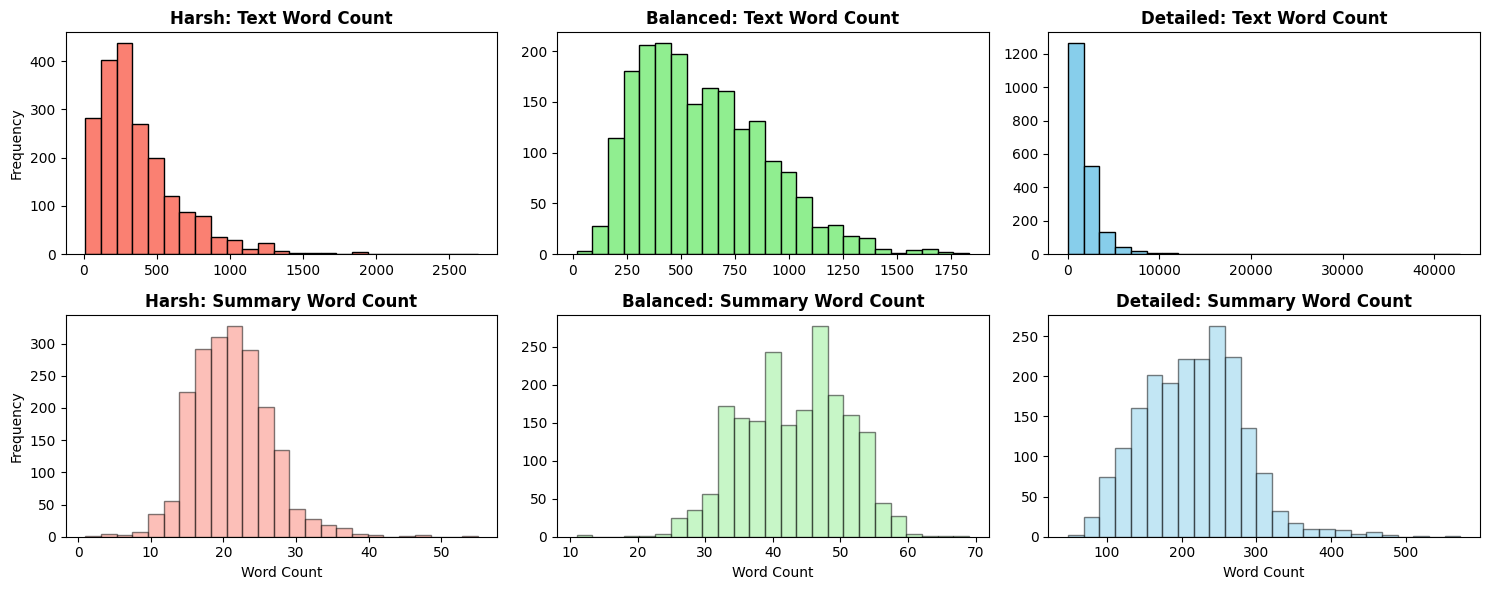

In [92]:
def plot_word_distributions(dfs, labels):
  n = len(dfs)
  plt.figure(figsize=(5 * n, 6))
  
  colors = ['salmon', 'lightgreen', 'skyblue']
  
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.hist(dfs[i]['textWordCount'], bins=25, color=colors[i], edgecolor='black', alpha=1.0)
    plt.title(f'{labels[i]}: Text Word Count', fontweight='bold')
    if i == 0:
      plt.ylabel('Frequency')

  for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.hist(dfs[i]['summaryWordCount'], bins=25, color=colors[i], edgecolor='black', alpha=0.5) 
    plt.title(f'{labels[i]}: Summary Word Count', fontweight='bold')
    plt.xlabel('Word Count')
    if i == 0:
      plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()

plot_word_distributions([harsh_df, balanced_df, detailed_df], ["Harsh", "Balanced", "Detailed"])